## Logistic Regression
- Using Keras 
- Using small training set due to compute burden 

In [3]:
# Importing the necessary libraries
from importlib import reload
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import math
from sklearn import metrics as sklearn_metrics

import augmentor
import constants

### Load Images

In [3]:
# Load Training augmented data for Count 250 
count = 250
path = constants.get_training_augmented_path_with_count_suffix(count=count)
aug = augmentor.Augmentor(dir_path=path)
# aug.augment(count)

# Return all images in a np.Array 
x_train, y_train = aug.get_numpy_data()

# Load validation data in np.Array. To limit the num of images loaded pass limit=250
x_val, y_val  = constants.load_validation_split_data_with_labels(limit = 850, resize=(244,244))

# Load Test data in np.Array.  To limit the num of images loaded pass limit=250
x_test, y_test = constants.load_testing_split_data_with_labels(limit = 1000, resize=(244,244))

In [7]:
#normalize pixel data
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test/ 255

In [11]:
#reshape y for val and test to match (x,y) shape for y_train
nsamples, nx, ny = y_val.shape
y_val = y_val.reshape((nsamples, nx*ny))

nsamples, nx, ny = y_test.shape
y_test = y_test.reshape((nsamples, nx*ny))

In [12]:
y_train.shape

(2000, 8)

In [13]:
y_val.shape

(850, 8)

In [14]:
y_test.shape

(1000, 8)

### Build Model 

In [15]:
def build_model(n_classes, learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

      Args:
        n_classes: Number of classes in the dataset
        learning_rate: The desired learning rate for SGD.

      Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    metrics = [
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.CategoricalAccuracy(name='acc'),
        keras.metrics.AUC(name='auc')]

    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        use_bias=True, 
        kernel_initializer=tf.ones_initializer
    ))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics= metrics)
    
    return model

In [16]:
label_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
NUM_OF_CLASSES = len(label_names)

In [17]:
#build model, using 100 epochs
model = build_model(NUM_OF_CLASSES)

history = model.fit(
  x = x_train,
  y = y_train,
  epochs=100,
  batch_size=10,
  verbose=0,
  validation_data=(x_val, y_val))

history = pd.DataFrame(history.history)
display(history)

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-07 06:13:45.343 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:45 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-07 06:13:45.400 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:45 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


,loss,precision,recall,acc,auc,val_loss,val_precision,val_recall,val_acc,val_auc
0,561.824707,0.145729,0.1450,0.1455,0.512944,158.617157,0.298824,0.298824,0.298824,0.602083
1,418.175232,0.188500,0.1885,0.1885,0.536647,254.221283,0.117647,0.117647,0.117647,0.495886
2,387.879425,0.212500,0.2125,0.2125,0.551031,129.850540,0.482353,0.482353,0.482353,0.707425
3,361.633331,0.237500,0.2375,0.2375,0.563766,229.511917,0.176471,0.176471,0.176471,0.532266
4,293.999207,0.242000,0.2420,0.2420,0.568322,449.495361,0.063529,0.063529,0.063529,0.461012
...,...,...,...,...,...,...,...,...,...,...
95,316.764679,0.404000,0.4040,0.4040,0.660692,442.048737,0.149412,0.149412,0.149412,0.514475
96,240.678772,0.454000,0.4540,0.4540,0.689941,417.494843,0.229412,0.229412,0.229412,0.560574
97,242.775833,0.421000,0.4210,0.4210,0.669901,319.544952,0.283529,0.283529,0.283529,0.592068
98,187.980225,0.477239,0.4770,0.4775,0.704187,249.542511,0.288235,0.288235,0.288235,0.594392


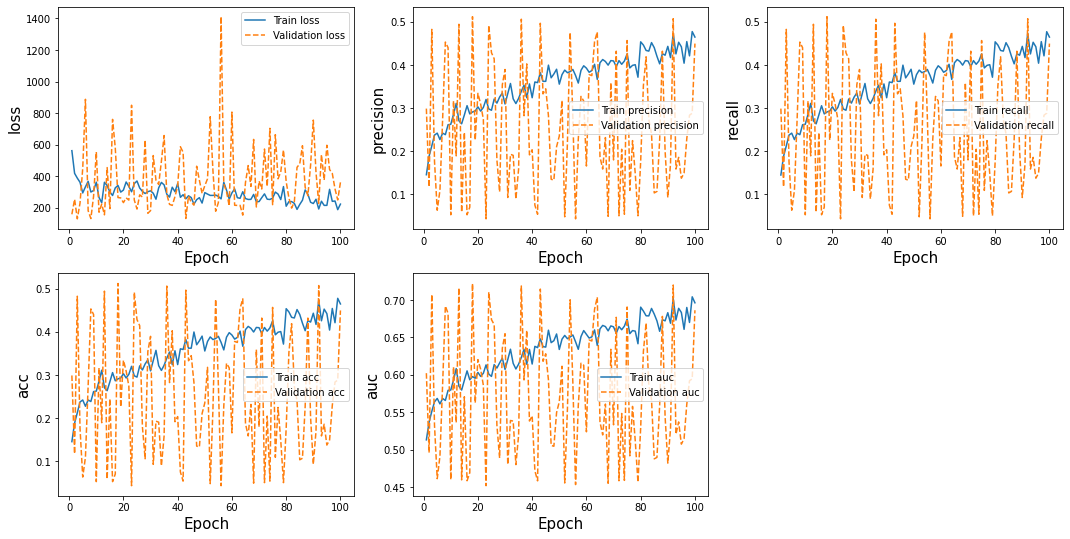

In [18]:
#Plot performance of model on train and validation set

def plot_history_df(history_df: pd.DataFrame):
    x_arr = np.arange(len(history_df['loss'])) + 1

    fig = plt.figure(figsize=(18, 9))
    for i, metric in enumerate(["loss", "precision", "recall", "acc", "auc"]):
        ax = fig.add_subplot(2, 3, i+1)
        ax.plot(x_arr, history_df[metric], '-', label=f'Train {metric}')
        ax.plot(x_arr, history_df[f'val_{metric}'], '--', label=f'Validation {metric}')
        ax.legend(fontsize=10)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel(metric, size=15)

plot_history_df(history)

In [40]:
# Taking a quick peek at the output
idx = 4
example_output = model.predict(x_val[idx:idx+1])[0]
display(example_output)

# What it's supposed to be
display(y_val[idx])

# categorical crossentropy loss
tf.keras.metrics.categorical_crossentropy(y_val[idx], example_output)

array([0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

array([1., 0., 0., 0., 0., 0., 0., 0.])

<tf.Tensor: shape=(), dtype=float32, numpy=16.118095>

In [22]:
# Save model and history
model.save("saved_models/logistic_regression/logistic_regression_2k_model.h5")
history.to_csv("saved_models/logistic_regression/logistic_regression_2k_model_history.csv")

Visualizing logistic regression weights

In [ ]:
model_weights = model.weights[0].numpy()

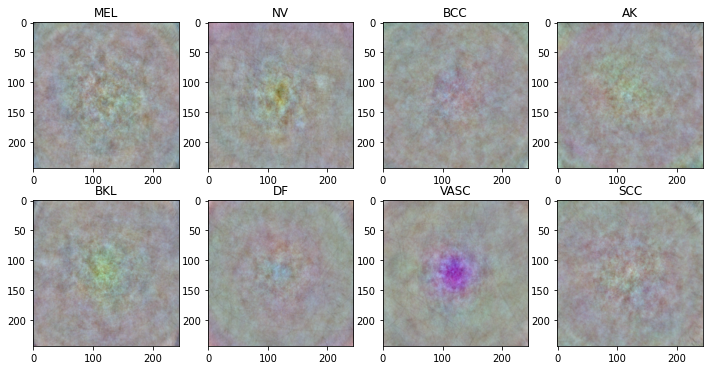

In [38]:
labels=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
fig = plt.figure(figsize=(12, 6))
for n, c in enumerate(labels):
    one_label_weights = model_weights[:, n].reshape(244, 244, 3)
    ax = fig.add_subplot(2, 4, n+1)
    plt.imshow(((one_label_weights / 5 + 1) * (255 / 2)).astype(int))
    plt.title(c);

## Evaluating with test dataset

In [4]:
# Load the correct test set
random_seed = 21
test_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_testing_split_class_path(),
    seed=random_seed,
    image_size=(244, 244),  # note: this is different from CNN models (224, 224)
    batch_size=10,
    label_mode='categorical',
    class_names=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    shuffle=False,
)

# # Reload model from saved file if spun up from scratch
# model = tf.keras.models.load_model("saved_models/logistic_regression/logistic_regression_2k_model.h5")

# model.compile(
#     loss='categorical_crossentropy',
#     optimizer="adam",
#     metrics=[
#         keras.metrics.Precision(name='precision'),
#         keras.metrics.Recall(name='recall'),
#         keras.metrics.CategoricalAccuracy(name='acc'),
#         keras.metrics.AUC(name='auc')
#     ],
# )

Found 5066 files belonging to 8 classes.


In [112]:
test_results = model.evaluate(test_ds)

507/507 [==============================] - 12s 23ms/step - loss: 98930.6250 - precision: 0.4591 - recall: 0.4591 - acc: 0.4591 - auc: 0.6909


In [23]:
#Evaluation of the model on the test set

test_results = model.evaluate(x_test, y_test)
print('\nTest Accuracy {:.2f}%'.format(test_results[3]*100))
print('\nTest Precision {:.2f}%'.format(test_results[1]*100))
print('\nTest Recall {:.2f}%'.format(test_results[2]*100))
print('\nTest ROC AUC score {:.2f}%'.format(test_results[4]*100))



32/32 [==============================] - 1s 9ms/step - loss: 397.6646 - precision: 0.4650 - recall: 0.4650 - acc: 0.4650 - auc: 0.6946

Test Accuracy 46.50%

Test Precision 46.50%

Test Recall 46.50%

Test ROC AUC score 69.46%


In [121]:
test_ds_labels = np.array(list(test_ds.map(lambda x, y: y).unbatch().as_numpy_iterator()))

In [122]:
#Generate predictions and change shape of y_pred and y_test for Sklearn classification report. 
y_pred_test = model.predict(test_ds)
y_pred_test_class = np.argmax(y_pred_test, axis=1)
y_test_2 = np.argmax(test_ds_labels, axis=1)

In [125]:
labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
print('Logistic Regression Classification Report')
print(sklearn_metrics.classification_report(y_test_2,y_pred_test_class, labels=range(8), target_names=labels, digits=3))
print(f"Accuracy: {sklearn_metrics.accuracy_score(y_test_2,y_pred_test_class):.4f}")
#'ovr' Stands for One-vs-rest. Computes the AUC of each class against the rest
print(f"ROC AUC: {sklearn_metrics.roc_auc_score(y_test_2,y_pred_test, multi_class='ovr'):.4f}")

Logistic Regression Classification Report
              precision    recall  f1-score   support

         MEL      0.464     0.153     0.230       895
          NV      0.708     0.788     0.746      2592
         BCC      0.000     0.000     0.000       684
          AK      0.000     0.000     0.000       160
         BKL      0.243     0.054     0.088       502
          DF      0.000     0.000     0.000        44
        VASC      0.500     0.170     0.254        47
         SCC      0.064     0.782     0.118       142

    accuracy                          0.459      5066
   macro avg      0.247     0.243     0.180      5066
weighted avg      0.475     0.459     0.437      5066

Accuracy: 0.4591
ROC AUC: 0.5760


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix 

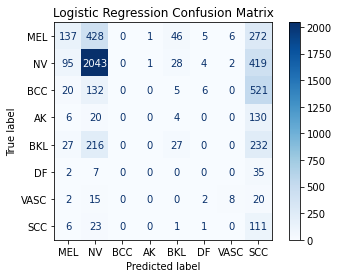

In [130]:
#Confusion matrix: 
cm = sklearn_metrics.confusion_matrix(y_test_2, y_pred_test.argmax(axis=1))
cm
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(); 